In [80]:
# pip install rtree

In [81]:
import trimesh
import numpy as np

model = trimesh.load('./obj/model.stl')
samples, face_indexes = trimesh.sample.sample_surface_even(model, 300)
samples_origin = samples.copy() 

In [82]:
normals = []

for i in range(len(samples)):
    sample = samples[i]  # 표면 위의 샘플링된 점
    face_index = face_indexes[i]  # 해당 점이 속한 삼각형 면의 인덱스

    # 삼각형 면의 노말 벡터 가져오기
    normal = model.face_normals[face_index]

    # 샘플 점에서의 노말 벡터 추가
    normals.append(normal)

In [83]:
# samples

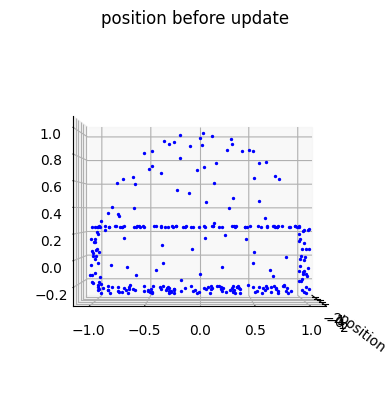

In [84]:
import matplotlib.pyplot as plt

# nums의 최소값과 최대값 구하기
min_num = np.min(samples)
max_num = np.max(samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(samples)):

    # 샘플링된 점 그리기
    ax.scatter(samples[i][0], samples[i][1], samples[i][2], marker= 'o', s=2, color='b')

ax.view_init(elev=0, azim=0)

plt.title('position before update')
plt.xlabel('position')
plt.show()

In [85]:
# from scipy.stats import norm
# 
# count = 0
# 
# while count < 100:
#     
#     # dens = []
#     vec = []
#     
#     for i in range(len(samples)):
#         # sum_pdf = 0
#         vec_total = 0
#         # 여기에 가우시안 넣어야 될듯
#         for num2 in samples:
#             if not np.array_equal(samples[i], num2):
#                 # gaussian 커널로 점들간 거리에 따라 확률추정
#                 # 이게 벡터의 크기
#                 distance = np.linalg.norm(samples[i] - num2)
#                 p = norm.pdf(distance, 0, 0.1)
#                 # 점 num에서 확률추정
#                 # sum_pdf += p
#                 vec_total += p * (samples[i]-num2) /distance
#                 
#                 vec_total += p * np.subtract(samples[i] - num2, np.dot(samples[i] - num2, normals[i]) * normals[i])
#                 # tangent = np.subtract(v1, np.dot(v1, normals[i]) * normals[i])
#                 
#         # dens.append(sum_pdf / (len(samples)-1))
#         vec.append(0.01 * vec_total)
#     
#     # dens /= np.sum(dens)
#     samples += vec
#     count += 1

In [ ]:
# from scipy.stats import norm
# import numpy as np
# from scipy.spatial.distance import cdist
# from scipy.spatial import cKDTree
# 
# # 가우시안 커널 함수
# def gaussian_kernel(x, sigma=0.1):
#     return np.exp(-0.5 * (x / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
# 
# count = 0
# enp = [float('inf')]
# 
# vertices = model.vertices
# tree = cKDTree(vertices)
# 
# while True:
#     distance = cdist(samples, samples)
# 
#     np.fill_diagonal(distance, np.inf)
# 
#     # 가우시안 커널 밀도 계산
#     pdf_matrix = gaussian_kernel(distance)
# 
#     # 1. 점에서 가장 가까운 꼭짓점 좌표 3개 선택
#     
#     # 벡터곱 (크로스 곱)으로 법선 벡터 계산
#     normal_vector = np.cross(adjust_v1, adjust_v2)
#     # 3. 벡터에서 노말벡터 성분 빼기
#     vec_final = np.subtract(vec, dot_product[:, np.newaxis]) * normal_vector
#     
#     # 엔트로피 계산
#     current_entropy = -np.sum(dens * np.log(dens))
# 
#     enp.append(current_entropy)
# 
#     # 엔트로피 변화가 일정부분 이하일 때 중지
#     if abs(enp[-2] - current_entropy) < 1e-5 and current_entropy == min(enp):
#         break
# 
#     samples += 0.009 * vec  # vec의 크기 조절

In [86]:
from scipy.stats import norm
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree

# 가우시안 커널 함수
def gaussian_kernel(x, sigma=0.1):
    return np.exp(-0.5 * (x / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

# count = 0
enp = [float('inf')]

vertices = model.vertices
faces = model.faces
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

while True:
    distance = cdist(samples, samples)

    np.fill_diagonal(distance, np.inf)

    # 가우시안 커널 밀도 계산
    pdf_matrix = gaussian_kernel(distance)

    # 각 점에서의 밀도 및 벡터 업데이트 계산
    dens = np.sum(pdf_matrix, axis=1) / (len(samples) * (len(samples) - 1))
    vec = np.sum(pdf_matrix[:, :, np.newaxis] * (samples[:, np.newaxis, :] - samples[np.newaxis, :, :]) / distance[:, :, np.newaxis], axis=1)

    ## 이제 벡터를 표면에 투영
    # 1. 점에서 가장 가까운 꼭짓점 좌표 3개 선택
    closest_points, _, triangle_ids = mesh.nearest.on_surface(samples)
    normal_vector = mesh.face_normals[triangle_ids]

    # 각 벡터에 대한 내적을 계산하여 vec와 normal_vector의 차원을 맞춤
    dot_product = np.sum(vec * normal_vector, axis=1)
    
    # vec에서 normal_vector 방향 성분을 제거하여 최종 vec 구하기
    vec_final = np.subtract(vec, dot_product[:, np.newaxis] * normal_vector)
    
    # 엔트로피 계산
    current_entropy = -np.sum(dens * np.log(dens))

    enp.append(current_entropy)

    # 엔트로피 변화가 일정부분 이하일 때 중지
    if abs(enp[-2] - current_entropy) < 1e-4 and current_entropy == min(enp):
        break

    samples += 0.009 * vec  # vec의 크기 조절

In [87]:
# from scipy.spatial import cKDTree
# vertices = model.vertices
# tree = cKDTree(vertices)
# 
# _, index = tree.query(samples, k=3)
# 
# index
# sv = vertices[index]
# svm = np.array(sv)

In [88]:
# adjust_v1 = svm[:,0]-svm[:,1]
# adjust_v2 = svm[:,0]-svm[:,2]
# normal_vector = np.cross(adjust_v1, adjust_v2)
# vec_final = np.subtract(vec, np.dot(vec, normal_vector) * normal_vector)

45


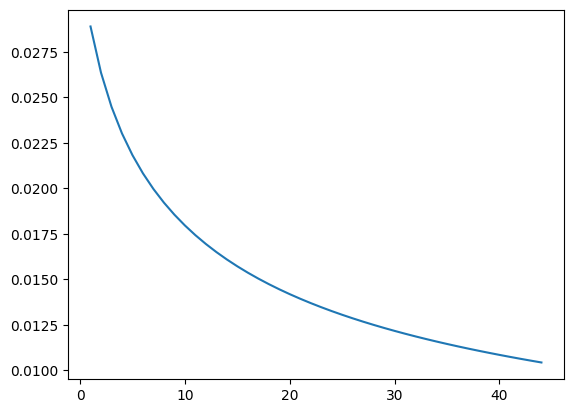

In [89]:
print(len(enp))
plt.plot(enp)

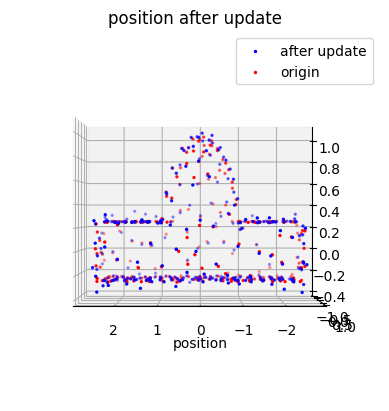

In [90]:
import matplotlib.pyplot as plt

# nums의 최소값과 최대값 구하기
min_num = np.min(samples)
max_num = np.max(samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 샘플링된 점 그리기
ax.scatter(samples[:,0], samples[:,1], samples[:, 2], marker= 'o', s=2, color='b', label="after update")
ax.scatter(samples_origin[:,0], samples_origin[:,1], samples_origin[:,2], marker= 'o', s=2, color='r', label="origin")

ax.view_init(elev=0, azim= 90)

ax.legend()
plt.title('position after update')
plt.xlabel('position')
plt.show()